## Cenário III

O Problema do Caixeiro Viajante (Traveling Salesperson - TSP) é um dos mais famosos problemas de otimização combinatória. Este problema é muito fácil de explicar, mas muito complicado de resolver - mesmo para casos com um pequeno número de cidades.

A origem do problema do caixeiro viajante não é muito clara; ele chega a ser mencionado em um manual de 1832 para caixeiros-viajantes, que incluía exemplos de passeios por 45 cidades alemãs, mas não foi formulado originalmente como um problema matemático. No entanto, em 1800, os matemáticos William Rowan Hamilton e Thomas Kirkman criaram formulações matemáticas do problema.

O TSP pode ser definido da seguinte forma: para uma determinada lista de cidades e as distâncias entre cada par delas, queremos encontrar a rota mais curta possível, que vai a cada cidade uma vez e retorna à cidade de origem.

Existe uma classe de Problemas de Pessoa Caixeira Viajante que assume que a distância de ir da cidade $ i $ à cidade $ j $ é a mesma que ir da cidade $ j $ à cidade $ i $, este tipo de TSP também é conhecido como TSP simétrico. Para o seguinte cenário sugerimos usar distâncias euclidianas, mas a formulação do modelo TSP é válida independentemente da forma como as distâncias individuais são determinadas.

A programação matemática é uma abordagem declarativa em que o modelador formula um modelo de otimização matemática que captura os principais aspectos de um problema de decisão complexo.

Um modelo de otimização matemática tipicamente vai possuir cinco componentes, a saber:

* Conjuntos e índices;
* Parâmetros;
* Variáveis ​​de decisão;
* Função (ões) objetivo (s);
* Quaisquer restrições.

Como entregável, a indústria necessita de uma formulação de TSP que identifique a rota mais curta para as capitais brasileiras, que vai a todas as cidades uma vez e retorna à cidade de origem (os arquivos a serem utilizados, contendo os dados das capitais brasileiras a serem utilizados nesse cenário, você encontra <a href="https://drive.google.com/drive/folders/1pip1P29vKGYWUOSD0hVrdNLNQcGzG3eN?usp=sharing">aqui</a>)

states_coords.csv: contém a latitude e longitude de cada capital de estado brasileiro;
states_line.json: contém o nome dos estados e a distância em km de todos os pares possíveis assumindo uma linha conectando as cidades;
states_gmaps.json: contém o nome dos estados e a distância em km de todos os pares possíveis com as informações do Google a respeito.


In [ ]:
#instala dependências
!pip install PuLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 38.2 MB/s eta 0:00:00


In [ ]:
#importa pacotes
import json
import pandas as pd
import numpy as np
import os
import gdown
from pulp import *
import zipfile
import networkx as nx
import matplotlib.pyplot as plt
import random

In [ ]:
def calc_rota(start,list_states):
  #calcula a sequencia correta de estados na forma de um tupla
  result=[]
  result.append(start)
  next=start[1]
  count = 0
  while True:
    for value in list_states:
      i,j=value
      if next==i and value not in result and (value[1],value[0]) not in result:
        result.append(value)
        next=j
        count += 1
    if next==start[0] or count>=20:
      break
  return result

In [ ]:
# faz o download dos dados
output = 'data_cen2.zip'
url='https://drive.google.com/uc?id=1aHu2I1tTVLs71GDPDDVx526_hL4mnLmy&export=download'

gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output,"r") as zip_ref:
      zip_ref.extractall()

os.remove(output)

Downloading...
From: https://drive.google.com/uc?id=1aHu2I1tTVLs71GDPDDVx526_hL4mnLmy&export=download
To: /content/data_cen2.zip
100%|██████████| 15.3k/15.3k [00:00<00:00, 10.9MB/s]


In [ ]:
# abre o arquivo 'data.json'
f = open('states_line.json')

# load JSON file as object
data = json.load(f)

In [ ]:
list_estados=data['nodes']
graph_estados=data['edges']

In [ ]:
#checa se temos valores nulos para as distancias entre cidades
sum([1 if (np.nan or None or 0.0) in line else 0 for line in graph_estados])

0

Não temos valores nulos, então vamos criar a matriz de adjacências:

In [ ]:
size_mat=len(list_estados) #quantidade de estados
graph=np.zeros((size_mat, size_mat)) #inicializa a matriz de adjacências com 0

In [ ]:
#Conjuntos e índices
#preenche a matriz de adjacências com as distancias entre as cidades
for estado in graph_estados:
  est_1=estado[0]
  est_2=estado[1]
  est_3=estado[2]
  graph[list_estados.index(est_1)][list_estados.index(est_2)]=est_3

# Formulando o Problema:

In [ ]:
#Parametros do modelo
arestas=[(i,j) for i in range(size_mat) for j in range(size_mat) if graph[i][j] != 0.0]

#Variaveis de decisão:
#variável auxiliar que diz a ordem em que os arcos são visitados, é continua entre 1 e numero de vértices
u=LpVariable.dicts("u",[i for i in range(size_mat)],lowBound=1,upBound=size_mat,cat='Continuous')
# variável contendo os indices (i,j) dos arcos, ela vale 1 se existir uma aresta do indice i para j e 0 caso contrário
v=LpVariable.dicts("x", arestas, cat = "Binary")

#Inicializa o modelo LP, para minimizar a função objetivo
TSP_solver=LpProblem("TSP",LpMinimize)

In [ ]:
#Adiciona a função objetivo ao modelo, para minimizar o custo total, calculado como somatorio do custo multiplicado pela variável v
TSP_solver += lpSum([graph[i,j] * v[i,j] for (i,j) in arestas])

#Adiciona as restrições ao TSP:
#Fixa os indices, e deve existir uma aresta do indice i para j, ou seja deve ser igual a 1
#Restrição 1:fixa o j
for j in range(size_mat):
    TSP_solver += lpSum([v[i,j] for (i,m) in arestas if m==j]) == 1

#Restrição 2:fixa o i
for i in range(size_mat):
    TSP_solver += lpSum([v[i,j] for (m,j) in arestas if m == i]) == 1

#Restrição 3, Eliminação de Sub-rotas, para fazer o ciclo ser conexo, considerando que o ponto de partida seja o nó 0,
#ou seja, São Paulo, portanto i deve ser diferente de 0 e i != j
for (i,j) in arestas:
    if i > 0 and i != j:
        TSP_solver += u[i] - u[j] + size_mat*v[i,j] <= size_mat-1

In [ ]:
#o modelo resolve o problema
#verificando o status do problema:
model_solve = TSP_solver.solve()
print(f"Status do Problema: {LpStatus[model_solve]}")

Status do Problema: Optimal


In [ ]:
#O problema tem uma uma solução ótima!

In [ ]:
#Imprime o Custo Total
print(f"Distância Total Percorrida= {round(value(TSP_solver.objective),4)} Km")

Distância Total Percorrida= 13717.6362 Km


In [ ]:
#Cria as tuplas de índices, ordenadas a partir das variáveis
index_sequence_states=[]
for var in TSP_solver.variables():
    if var.varValue > 0 and 'x' in var.name:
        i,j=var.name.replace('_','').replace('x(','').replace(')','').split(',')
        index_sequence_states.append((int(i),int(j)))

sequence_states=[]
sequence_states.append(index_sequence_states[0])

for obj in sequence_states:
  i,j=obj
  next=[val for val in index_sequence_states if val[0]==j and val not in sequence_states]
  if len(next)>0:
    sequence_states.append(next[0])

# Exibe o Caminho Ótimo ou Seja a Sequência de Estados à Serem Visitados, Considerando que o Ponto de Partida Seja o Nó 0, ou Seja, São Paulo:

In [ ]:
optimal_list_states=[]
print("Sequência de Estados à Serem Visitados:")
print("\nOrigem -> Destino:")
for value in sequence_states:
  i,j=value
  print(list_estados[i],'->',list_estados[j])
  optimal_list_states.append(list_estados[i])
optimal_list_states.append(list_estados[j])

Sequência de Estados à Serem Visitados:

Origem -> Destino:
São Paulo -> Rio de Janeiro
Rio de Janeiro -> Espírito Santo
Espírito Santo -> Minas Gerais
Minas Gerais -> Goiás
Goiás -> Tocantins
Tocantins -> Bahia
Bahia -> Sergipe
Sergipe -> Alagoas
Alagoas -> Pernambuco
Pernambuco -> Paraíba
Paraíba -> Rio Grande do Norte
Rio Grande do Norte -> Ceará
Ceará -> Piauí
Piauí -> Maranhão
Maranhão -> Pará
Pará -> Amapá
Amapá -> Roraima
Roraima -> Amazonas
Amazonas -> Rondônia
Rondônia -> Acre
Acre -> Mato Grosso
Mato Grosso -> Mato Grosso do Sul
Mato Grosso do Sul -> Rio Grande do Sul
Rio Grande do Sul -> Santa Catarina
Santa Catarina -> Paraná
Paraná -> São Paulo


In [ ]:
list_states=[(val[0],val[1]) for val in graph_estados]

In [ ]:
states_graph=[]
states_graph.append(optimal_list_states)

In [ ]:
for value in random.sample(list_states,50):
  start=value
  list_rotas=calc_rota(start,list_states)
  seq_states=[state[0] for state in list_rotas]
  seq_states.append(list_rotas[-1][-1])
  states_graph.append(seq_states)

# Visualizando o Grafo da Solução:

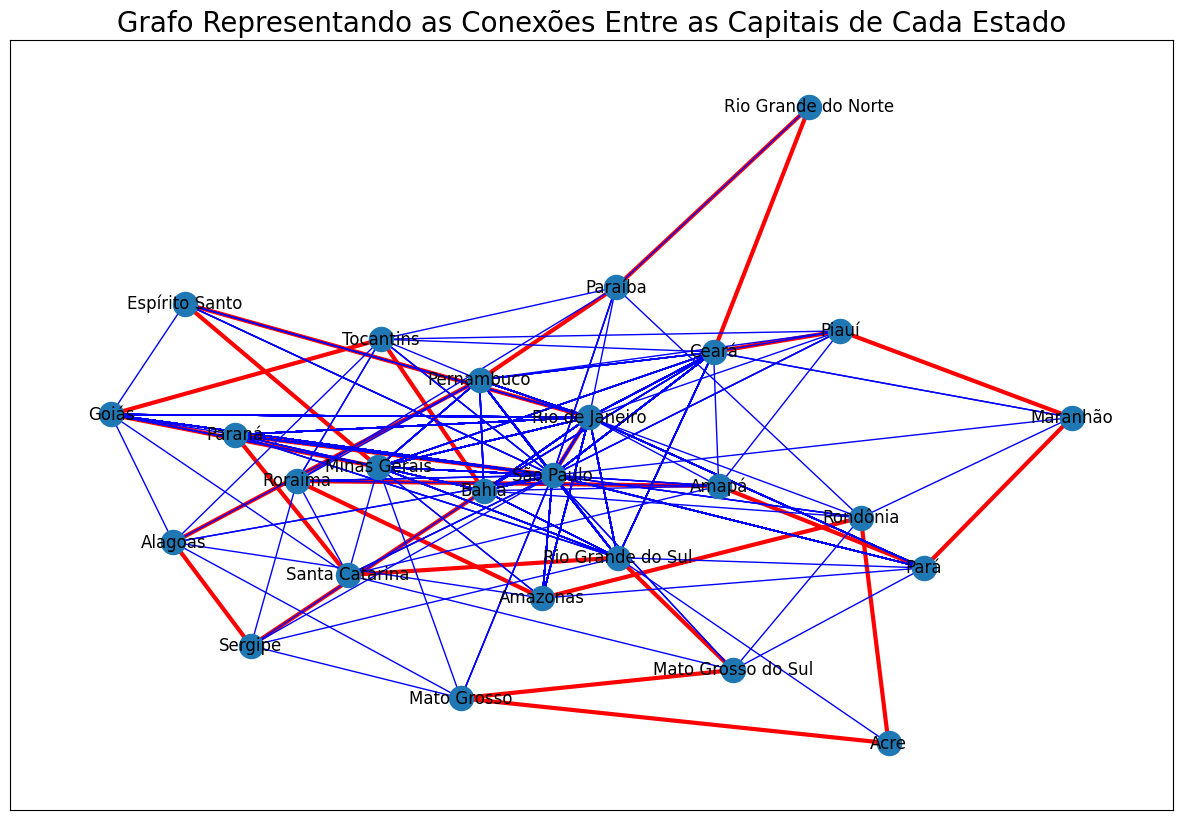

In [ ]:
G=nx.Graph(name="TSP")
plt.figure(figsize=(15,10))
edges = []
for r in states_graph:
    route_edges = [(r[n],r[n+1]) for n in range(len(r)-1)]
    G.add_nodes_from(r)
    G.add_edges_from(route_edges)
    edges.append(route_edges)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos=pos)
nx.draw_networkx_labels(G,pos=pos)
colors = ['r']
colors +=['b' for i in range(len(states_graph)-1)]
linewidths = [3]
linewidths +=[1 for i in range(len(states_graph)-1)]

plt.title("Grafo Representando as Conexões Entre as Capitais de Cada Estado",fontsize='20')

for ctr, edgelist in enumerate(edges):
    nx.draw_networkx_edges(G,node_size=400,pos=pos,edgelist=edgelist,edge_color = colors[ctr], width=linewidths[ctr])

plt.show()

Observação: Na imagem acima, o caminho ótimo é representado pela linha vermelha, e restante do grafo pela linha azul, não foi plotado o grafo completo pois além de ficar muito poluído, dificultando a visualização, demoraria muito tempo de processamento, o objetivo aqui é ter uma boa idéia, para visualizar o caminho ótimo em relação ao restante do grafo.

# EXPLICANDO O DESENVOLVIMENTO DA SOLUÇÃO:

Para a resolução desse cenário foi utilizada a biblioteca PuLP, para solucionar o problema de otimização combinatória do caixeiro viajante, para formulação do problema, foram definidas as *variáveis de decisão, conjuntos e índices, as resrições, os parâmetros e a função Objetivo*, conforme foi especificado no enunciado do problema, foi calculada a distância total percorrida, bem como se a solução é ideal, e a rota ótima partindo da cidade de origem: São Paulo e retornando a mesma cidade, por fim foi gerada uma visualização do grafo representando as conexões entre as capitais de cada estado, apenas para facilitar o entendimento.

# PROPOSTA DE MELHORIA:

Poderia serem exploradas implementações mais eficientes do algorítimo TSP, algumas implementações utilizam algorítimos genéticos, programação dinâmica, etc... que poderiam ter uma complexidade computacional menor, que a complexidade do espaço O(2^N).